In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [2]:
train = datas.MNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
test = datas.MNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())

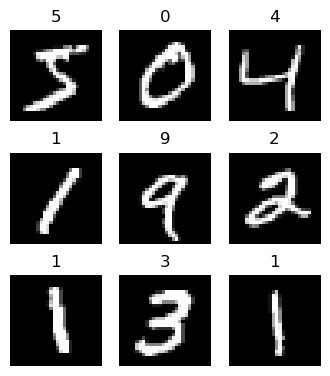

In [3]:
for i in range(9):
    image = train[i][0].numpy().squeeze()
    plt.subplot(3,3,i+1)
    plt.gcf().set_size_inches(4,4.5)
    plt.gca().axis('off')
    plt.imshow(image, cmap = 'gray') 
    plt.title(train[i][1])
#     print(train[i][1], end = ',')

In [4]:
total_batch = len(train)
data_per_batch = 500
batches = int(total_batch / data_per_batch)
iterations = 1500
epoch = int(iterations / data_per_batch)
batches

120

In [5]:
train_loader = DataLoader(train, batch_size = batches, shuffle = True)
validation_loader = DataLoader(test, batch_size = 5000, shuffle = False)

In [6]:
class classifying_model(nn.Module):
    def __init__(self, input_shapes, output_shapes):
        super(classifying_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 4, stride = 1, padding = 0)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4, stride = 1, padding = 0)
        
        self.fc = nn.Sequential(
                        nn.Linear(32*4*4, 225),
                        nn.ReLU(inplace = True),
                        nn.BatchNorm1d(225),
                        nn.Linear(225, output_shapes)
                        )
    def forward(self, x):
        out = self.maxpool(self.relu(self.conv1(x)))
        out = self.maxpool(self.relu(self.conv2(out)))
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [7]:
input_size = 28 * 28
learning_rate = 0.1

In [8]:
model = classifying_model(input_shapes = input_size, output_shapes = 10)
# model2 = CNNModel()


In [9]:
i, j = next(iter(train_loader))
i.view(-1, 28*28).shape

torch.Size([120, 784])

In [10]:
def training(model,train_loader, validation_loader, epoch = 6, batches = 120):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    print('started')
    itera = 0
    loss_list = []
    accuracy_list = []
    for i in range(epoch):
        for n, (images, label) in enumerate(train_loader):
    #         images = Variable(images.view(-1, 28 * 28))
            model.train()
            optimizer.zero_grad()
            pred = model(images)
            _, predictions = torch.max(pred, 1)
            accuracy = accuracy_score(predictions, label)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            itera += 1
            if n % 300 == 0:
                for j, (images, label) in enumerate(validation_loader):
    #                 images = Variable(images.view(-1, 28 * 28))
                    model.eval()
                    pre = model(images)
                    _, predictions = torch.max(pre, 1)
                    test_accuracy = accuracy_score(predictions, label)
                    test_loss = criterion(pre, label)


                print(f'{itera} | training_loss ---> {loss:.4f} | train_acc ---> {accuracy:.4f} | test_acc ---> {test_accuracy:.4f} | validating_loss ---> {test_loss:.4f}')
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
    print('finished')            
    return model, [loss_list, test_loss], [accuracy_list, test_accuracy], predictions, images, label

In [11]:
def plot_acc(loss_list, accuracy_list):# Plot the loss and accuracy
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_xlabel('epoch',color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot( accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()


## checking out some predictions made

tensor([3, 6, 5, 3, 5, 7, 9, 1, 0, 5, 3, 7, 1, 2, 9, 4, 7, 1, 4, 1, 0, 4, 7, 3,
        6])
tensor([3, 6, 5, 3, 5, 7, 9, 1, 0, 5, 3, 7, 1, 2, 9, 4, 7, 1, 4, 1, 0, 4, 7, 3,
        6])


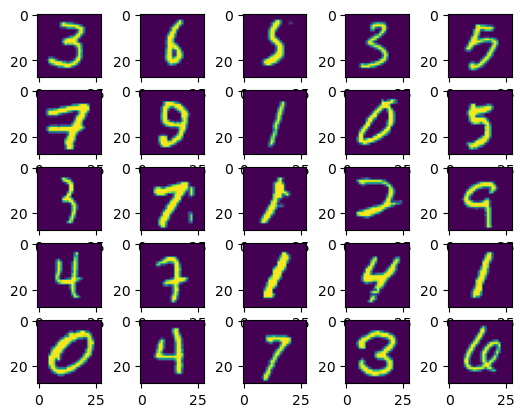

In [56]:
print(predictions[:25])
print(label[:25])
for i in range(25):
    plt.subplot(5,5,i+1 % 5)
    im = images[i].view(28, 28)
    plt.imshow(im)

## checking the wrong predictions made

 wrong predicted === tensor([2, 7, 9])
correct label === tensor([7, 2, 8])


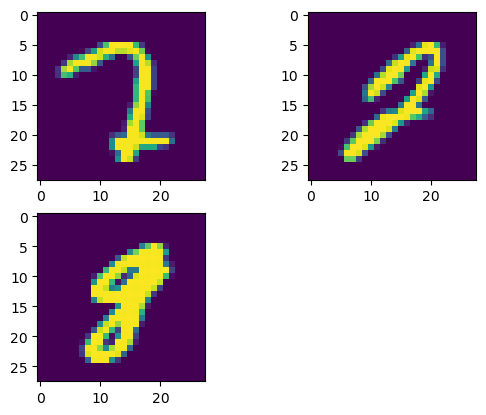

In [58]:
import math
print(f' wrong predicted === {predictions[predictions != label]}')
print(f'correct label === {label[predictions != label]}')
n_wrong = images[predictions != label].shape[0]
root = math.ceil(math.sqrt(n_wrong))
for i in range(n_wrong):
    plt.subplot(root, root,i+1 % 5)
    im = images[predictions != label][i].view(28, 28)
    plt.imshow(im)

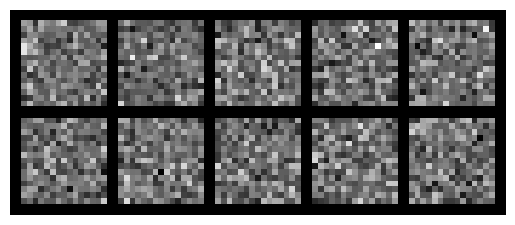

In [59]:
import torchvision
def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')
    
def display_thumb(img):
  display.display(transforms.Resize(128)(img))

assert model.fc[3].weight.shape == (10, 15 * 15)
show(torchvision.utils.make_grid(
    model.fc[3].weight.view(10, 1, 15, 15),
    normalize=True,
    nrow=5,
))

In [15]:
# plt.imshow(images[0].view(28, 28))

started
1 | training_loss ---> 2.4053 | train_acc ---> 0.0833 | test_acc ---> 0.3000 | validating_loss ---> 2.2559
301 | training_loss ---> 0.0898 | train_acc ---> 0.9750 | test_acc ---> 0.9884 | validating_loss ---> 0.0437
501 | training_loss ---> 0.0445 | train_acc ---> 0.9917 | test_acc ---> 0.9706 | validating_loss ---> 0.0931
801 | training_loss ---> 0.0367 | train_acc ---> 0.9917 | test_acc ---> 0.9936 | validating_loss ---> 0.0248
1001 | training_loss ---> 0.0517 | train_acc ---> 0.9833 | test_acc ---> 0.9882 | validating_loss ---> 0.0411
1301 | training_loss ---> 0.0373 | train_acc ---> 0.9833 | test_acc ---> 0.9954 | validating_loss ---> 0.0215
1501 | training_loss ---> 0.0581 | train_acc ---> 0.9667 | test_acc ---> 0.9930 | validating_loss ---> 0.0228
1801 | training_loss ---> 0.0166 | train_acc ---> 0.9917 | test_acc ---> 0.9926 | validating_loss ---> 0.0248
2001 | training_loss ---> 0.0266 | train_acc ---> 0.9917 | test_acc ---> 0.9962 | validating_loss ---> 0.0165
2301 | t

['model.pkl']

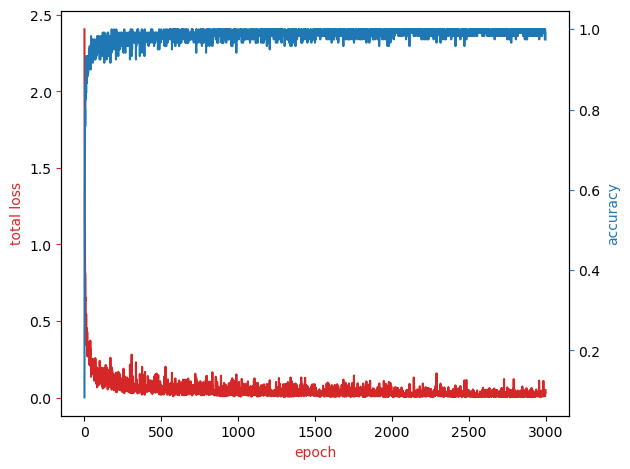

In [16]:
if __name__ == '__main__':
    model, [loss_list, test_loss], [accuracy_list, test_accuracy], predictions, images, label  = training(model, train_loader, validation_loader)
    plot_acc(loss_list, accuracy_list)
    
    # Save the entire model
import joblib
joblib.dump(model, 'model.pkl')

In [17]:
images.shape

torch.Size([120, 1, 28, 28])

In [26]:
i = images[0:3]
model(i)

tensor([[-2.0269, -2.2116, -0.5010, 11.8749, -3.1413, -2.4762, -8.7735,  5.3632,
         -2.5757,  6.0251],
        [ 1.7638,  0.9299,  0.0431, -6.0084,  0.4176, -1.3014, 10.5659, -3.3853,
          4.4468, -7.7289],
        [-0.1086,  0.9542,  0.6967, -5.5662,  2.6554,  3.8331, -2.4494, -2.2388,
         -0.8817,  1.7517]], grad_fn=<AddmmBackward0>)

In [14]:
im = train[2][0]
im.shape

torch.Size([1, 28, 28])

In [37]:
img.shape

torch.Size([28, 28])

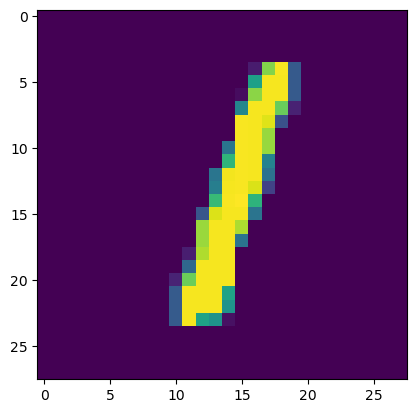

In [61]:
plt.imshow(images[19][0])

tensor(8)

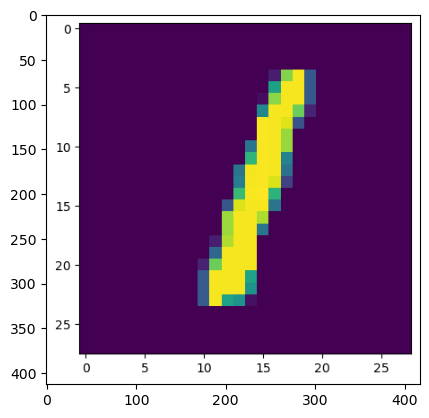

In [76]:
from PIL import Image
import joblib

mod = joblib.load('model.pkl')

png = Image.open('download2.png')
im = png.getchannel(3).resize([28, 28])
plt.imshow(png, cmap = 'gray')
img = np.array(im)
img = img.astype('float32')
img = np.resize(img, [28, 28]).reshape(1,1,28,28)
img = torch.Tensor(img)
batch_image = img.repeat(2, 1, 1, 1)
passed = mod(batch_image)
_, prediction = torch.max(passed, 1)
prediction[0]

In [49]:
img.shape

(1, 1, 28, 28)